# CCA Summer School: Landscape of Astronomical Transients

## Day 1: Introduction to Transient Surveys and Alert Streams

### Prepared by Kohki Uno
- Research Interests: Supernovae, TDEs, and Weird Transients
- Affiliation: Kyoto University -> Columbia University
- Email: <k.uno@kusastro.kyoto-u.ac.jp> or <ku2204@columbia.edu>
- HP: <https://www.kusastro.kyoto-u.ac.jp/~k.uno/view/index.html>

---

# Today's Goals and Summary
- Get familiar with the data and technique of transient surveys
- Understand the structure of the original ZTF alert
- Subscribe to the ZTF data via the ALeRCE broker, reconstruct each object's light curve, and handle the data


Three assignments have been prepared for you. Please work through them.

---

# Step 0: Environment Setup

As the first step, I suggest you to create a new python environment (I use Python 3.10):
`conda create -n lsstss2025`, and activate the env and install the following python module.

## Required Python Packages:
install  using `pip` or `conda`
- [Astropy](https://www.astropy.org/): Common core package for astronomy
- [Numpy](https://numpy.org/): Scientific mathmatical package
- [Scipy](https://scipy.org/): Scientific mathmatical package
- [Pandas](https://pandas.pydata.org/): Data analysis package
- [Matplotlib](https://matplotlib.org/): Visuallization package
- [fastavro](https://fastavro.readthedocs.io/en/latest/): for ZTF alert
- [alerce.core](https://alerce.readthedocs.io/en/latest/): API for ALeRCe (only for pip)

In [97]:
import os
import json
import time
from fastavro import reader
import gzip, io
import random

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u

from alerce.core import Alerce
alerce = Alerce()  # no authentication needed

Set up the save directory (Although it's included in the GitHub repository, it is defined here just in case.)

In [2]:
output_dir = './output_day1/'
os.makedirs(output_dir, exist_ok=True)

## Ancilliary Datasets:

The following materials are already included in the GitHub repository (`LSST_summer_school_2025_Flatiron/day2_ccsne`).
If you successfully fork the repository, these files will be downloaded automatically.

- `/public_ztf_alert/2765241404615015018.avro`: a single ZTF public alert file
- (`alerce_classifiers.json`: a json file for summerizing alerce classifer (not explicitly use in this notebook))

In addition, you need to download the following large file from <https://www.dropbox.com/scl/fi/df4ctlq2qgbatejtmca2y/day1_ztf_alert_20240728_min.json?rlkey=dskd8aup6joaycitoj74gmrit&st=hdcvsdad&dl=0>, and put the file in `./output_day2/`.

- `day1_ztf_alert_20240728_min.json`: a json file for ZTF alerts

---

# Step 1: Get Familiar with Transient Survey

## What is a transient survey?

A transient survey is an time-domain observational program designed to discover and monitor astronomical transients that change in brightness or position over short timescales (from seconds to months). 

These transient phenomena include:
- Supernovae (SNe)
- Gamma-ray bursts (GRBs)
- Tidal disruption events (TDEs)
- Variable stars
- Active galactic nuclei (AGN)
- Moving objects like asteroids  etc...

Transient surveys use wide-field (FOV > several square deg) telescopes, and rapid, repeated imaging of the sky to detect these short-timescale events. The goal of the surveys is to detect and characterize such events as immediately and as completely as possible, and connect to detailed follow-up observations.

Such surveys have transformed time-domain astronomy, enabling statistical studies of transient rates, real-time alerts, and rapid follow-up with ground- and space-based telescopes.

## ZTF: Zwicky Transient Facility

[The Zwicky Transient Facility (ZTF)](https://www.ztf.caltech.edu/index.html) is the most powerful time-domain survey using a 48-inch (1.2-meter) Schmidt telescope at the Palomar Observatory. Operational since 2018, ZTF has been scaning the Northern sky every a few nights.

Key features of ZTF (see also [Link](https://www.ztf.caltech.edu/ztf-camera.html)):
- FOV: 47 square degrees (3750 deg^2 / hour) !
- Cadence: $\sim$ 3 days
- Filters: g / r/ i
- limiting mag (5-sigma 30sec): 20.8 / 20.6 / 19.9
- Targets:
    - fast, young, and rare transients
    - counterparts to GW sources
    - low-z Type Ia SNe for cosmology
    - variable stars & eclipsing binaries
    - solar system objects    etc...

## Rubin Observatory / LSST survey
[The Vera C. Rubin Observatory](https://rubinobservatory.org/) is a next-generation transient surve using 8.4-meter telescope at Chele. Rubin The will perform 10-year Southern-Hemisphere survey called [the Legacy Survey of Space and Time (LSST)](https://rubinobservatory.org/explore/how-rubin-works/lsst). Revently, it has started operations, and a lot of interesting and suprigin repots will come out! 


Key features of Rubin/LSST:
- 9.6 square degrees field of view
- Cadence: $\sim$ 5 days (but depending on the survey mode; maximum  $\sim$ 17 days)
- Filters: u / g / r / i / z / y
- limiting mag (5-sigma 30sec): 23.9 / 25.0 / 24.7 / 24.0 / 23.3 / 21.1
- Targets:
    - exporing optical transient
    - probing dark energy & dark matter
    - taking an inventory of the Solar system 
    - mapping the Milky Way

The LSST will generate a data volume of $\sim$ 20TB per night, producing alerts for ~10 million transient events per night ($\sim$ 60 PB in 10 years, see also [Link](https://www.lsst.org/about/dm)) — revolutionizing time-domain astronomy.

To prepare for the upcoming LSST era, today’s hands-on exercise will focus on getting you familiar with how to handle data from ZTF alert streams. In addition, we will explore data provided by brokers — community tools that process alert streams from ZTF and from LSST in the future. By working with both raw alerts and broker-enhanced data, you'll gain practical experience with real-world survey data and learn how to efficiently filter, analyze, and interpret transient events.

This exercise will provide practical experience with real-world survey data and learn how to efficiently filter, analyze, and interpret transient events, which will also help build foundational skills necessary for scientific discovery in the LSST era.

## Step 1-1: Accessing and handling the public ZTF Alert Stream

The environment might has been successfully set up. Now let’s begin the today's hands-on exercise.

Public ZTF alerts for each night are available from the following page: <https://ztf.uw.edu/alerts/public/>

As you can see, the alert data for a single night typically reaches $\sim$ 10 GB! Downloading this full dataset even for one night can take a significant amount of time.
To save time, a sample data of one alert has already been prepared and stored in: `./output_day1/public_ztf_alert`. This data is alerted on 2024/Jul/28 (just one year ago).

If you are interested in exploring the full ZTF public alert data yourself, you can uncomment the code in the following cell.
However, this is optional and intended as homework.

In [ ]:
# We use the data observed on 2024/July/28 
# !wget https://ztf.uw.edu/alerts/public/ztf_public_20240728.tar.gz

In the directory, you will find an Avro file named `2765241404615015018.avro`.
This file represents a single ZTF public alert. A full one-night's alerts typically consists of $>10^{4}$ Avro files.

Let’s open this sample Avro file and see what data are stored in?

In [3]:
avro_dir = os.path.join(output_dir, 'public_ztf_alert')
avro_path = os.path.join(avro_dir, "2765241404615015018.avro")

with open(avro_path, 'rb') as f:
   alert = list(reader(f))
   
alert = alert[0]
print(alert.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'fp_hists', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


You can see dict data named as.
- `schemavsn` – Version number of the alert schema format.
- `publisher` – Organization or system that issued the alert (e.g. "ZTF").
- `objectId` – Unique identifier for the astrophysical object associated with the alert. (i.e., ZTF name)
- `candid` – Unique ID for this specific detection (candidate) of the object.
- `candidate` – Dictionary containing observational data from this detection (e.g., time, magnitude, RA/Dec).
- `prv_candidates` – List of previous detections of the same object, useful for building light curves.
- `fp_hists` – Historical false-positive diagnostic information (optional, often unused).
- `cutoutScience` – Base64-encoded image stamp of the science observation.
- `cutoutTemplate` – Base64-encoded image stamp of the reference template.
- `cutoutDifference` – Base64-encoded image stamp of the difference (science - template).

In each ZTF alert, the contentd str stored as dictionary-like style.

As one example, let's check data are stored in `candidate`.

In [4]:
alert['candidate']

{'jd': 2460519.7414005,
 'fid': 1,
 'pid': 2765241404615,
 'diffmaglim': 20.680885314941406,
 'pdiffimfilename': 'ztf_20240728241366_000764_zg_c12_o_q3_scimrefdiffimg.fits',
 'programpi': 'Kulkarni',
 'programid': 1,
 'candid': 2765241404615015018,
 'isdiffpos': 't',
 'tblid': 18,
 'nid': 2765,
 'rcid': 46,
 'field': 764,
 'xpos': 1835.914794921875,
 'ypos': 1449.7342529296875,
 'ra': 268.2425409,
 'dec': 48.2190436,
 'magpsf': 19.35249137878418,
 'sigmapsf': 0.10508867353200912,
 'chipsf': 1.687592625617981,
 'magap': 19.58679962158203,
 'sigmagap': 0.13740000128746033,
 'distnr': 1.7052985429763794,
 'magnr': 21.73900032043457,
 'sigmagnr': 0.11999999731779099,
 'chinr': 0.8730000257492065,
 'sharpnr': 0.07900000363588333,
 'sky': 0.11771140247583389,
 'magdiff': 0.23430900275707245,
 'fwhm': 2.359999895095825,
 'classtar': 0.9810000061988831,
 'mindtoedge': 1236.585205078125,
 'magfromlim': 1.0940855741500854,
 'seeratio': 1.1219043731689453,
 'aimage': 0.7020000219345093,
 'bimage'

The important data in `candidates` are:
- `objectId`: A unique identifier for the astronomical source.
- `candid`: A unique ID for the specific detection (each alert has one).
- `ra`, `dec`: Right ascension and declination of the candidate in degrees (J2000).
- `jd`: Julian Date of the observation.
- `magpsf`: magnitude of the detection by PSF (Point Spread Function) fitting.
- `sigmapsf`: Uncertainty of `magpsf`.
- `magap`: magnitude of the detection by apperture photometry.
- `sigmagap`: Uncertainty of `magap`.
- `fid`: Filter ID (1 = g-band, 2 = r-band, 3 = i-band).
- `drb`: Real–Bogus score (machine-learned probability that the source is astrophysical).

This is a detection alert in the night.

Furthermore, the Avro file include `cutout` files. These are stamp images of the detections. 

Let's Vizualize the stamp images!!

`get_stamp_image(alert, which)`

Extract and return a 2D FITS image array (stamp) from a ZTF alert packet.

Arguments:
- `alert` (dict): A ZTF alert dictionary containing compressed FITS cutout data.
- `which` (str): The image type to extract. Must be one of:
  - `'Science'`: Science image cutout.
  - `'Template'`: Reference image cutout.
  - `'Difference'`: Subtracted image cutout.

Returns:
- `numpy.ndarray`: A 2D image array corresponding to the selected cutout type.


In [6]:
def get_stamp_image(alert, which):

    # Extract gzip-compressed image data for the specified cutout type
    compressed = alert["cutout%s" % which]["stampData"]

    # Decompress the data using gzip and load as a FITS HDU
    with gzip.open(io.BytesIO(compressed), 'rb') as f:
        hdu = fits.open(io.BytesIO(f.read()), ignore_missing_simple=True)[0]

        # Return the image data as a 2D NumPy array
        return hdu.data

`plot_stamp_image(alert)`

Visualize the `Science`, `Template`, and `Difference` cutout images from a ZTF alert as a 3-panel plot.

Arguments:
- `alert` (dict): A ZTF alert dictionary that includes compressed cutout image data for `'Science'`, `'Template'`, and `'Difference'`.

Returns:
- `None`: Displays a Matplotlib figure with three grayscale image panels. Each panel uses percentile-based scaling (5–99%) to enhance contrast.

In [17]:
def plot_stamp_image(alert):

    # Retrieve each cutout image as a 2D NumPy array
    science_img   = get_stamp_image(alert, 'Science')
    template_img  = get_stamp_image(alert, 'Template')
    different_img = get_stamp_image(alert, 'Difference')

    # Create a 1x3 subplot layout
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    titles = ["Science", "Template", "Difference"]
    images = [science_img, template_img, different_img]

    # Display each image with percentile scaling for contrast
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(
            img,
            cmap='gray',
            origin='lower',
            vmin=np.percentile(img, 5),
            vmax=np.percentile(img, 99),
            # norm=LogNorm() if title != "Difference" else None
        )
        ax.set_title(title)
        ax.axis('off')  # Hide axis ticks and labels

    plt.tight_layout()
    plt.show()

Plot the stamp image!

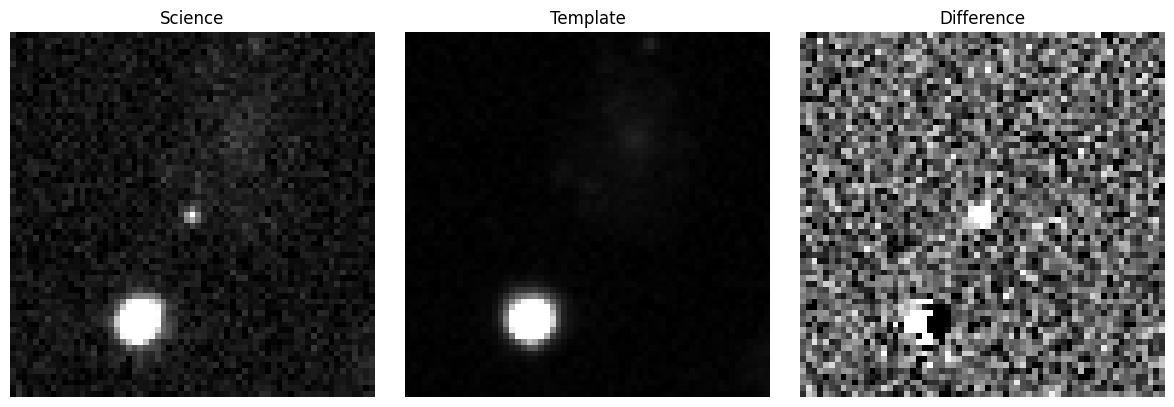

In [18]:
plot_stamp_image(alert)

`Science` is the observed image at the night, `Template` is the image of the reference, and `Difference` is the subtraction image. You can detect a luminous point at the center of the difference image. This is a transient!!

Then, you might be interested in the time variability of the detected object.
ZTF alerts include not only the most recent detection (`candidate`), but also previous detections of the same object. These are stored in `prv_candidates`.

In [20]:
len(alert['prv_candidates']), alert['prv_candidates'][0]

(44,
 {'jd': 2460489.7580671,
  'fid': 1,
  'pid': 2735258063515,
  'diffmaglim': 20.68160057067871,
  'pdiffimfilename': '/ztf/archive/sci/2024/0628/258009/ztf_20240628258009_000763_zg_c09_o_q4_scimrefdiffimg.fits.fz',
  'programpi': 'Kulkarni',
  'programid': 1,
  'candid': 2735258063515015012,
  'isdiffpos': 't',
  'tblid': 12,
  'nid': 2735,
  'rcid': 35,
  'field': 763,
  'xpos': 1580.2099609375,
  'ypos': 1360.72998046875,
  'ra': 268.2425531,
  'dec': 48.2190589,
  'magpsf': 19.84429931640625,
  'sigmapsf': 0.1574079990386963,
  'chipsf': 1.2527999877929688,
  'magap': 20.188600540161133,
  'sigmagap': 0.23350000381469727,
  'distnr': 0.9299929738044739,
  'magnr': 21.85099983215332,
  'sigmagnr': 0.1899999976158142,
  'chinr': 1.7230000495910645,
  'sharpnr': 0.33000001311302185,
  'sky': 0.4758079946041107,
  'magdiff': 0.3442879915237427,
  'fwhm': 2.5299999713897705,
  'classtar': 0.9629999995231628,
  'mindtoedge': 1360.72998046875,
  'magfromlim': 0.4929879903793335,
  'se

`prv_candidates` contains previous detection data for the same object.
The format of each entry is similar to that of `candidate`, but `prv_candidates` provides a time series of past detections. This time-series information allows us to plot the light curve!!

Let’s plot a light curve using this data!

`plot_ztf_prv_lightcurve(alert)`

Plot a light curve using previous candidates from a ZTF alert packet. Both PSF and aperture photometry are displayed for available bands.

Arguments:
- `alert` (dict): A ZTF alert dictionary containing the `'prv_candidates'` key, which includes privious photometric detections.

Returns:
- `None`: Displays a Matplotlib light curve plot with error bars.


In [22]:
def plot_ztf_prv_lightcurve(alert):

    detections = alert['prv_candidates']

    # Define filter ID to color/label mappings
    # fid = 1 (g: green), 2 (r: red), 3 (i: orange)
    band_colors = {1: 'green', 2: 'red', 3: 'orange'}
    band_labels = {1: 'g-band', 2: 'r-band', 3: 'i-band'}

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot detections by band
    if len(detections) > 0:
        for fid in sorted(set(d['fid'] for d in detections)):
            # Filter out entries missing photometry
            band_data = [
                d for d in detections
                if d['fid'] == fid and 'magpsf' in d and 'sigmapsf' in d
            ]
            if not band_data:
                continue

            # Extract photometry data
            jd = [d['jd'] for d in band_data]
            mag = [d['magpsf'] for d in band_data]
            err = [d['sigmapsf'] for d in band_data]

            # Extract aperture magnitudes if available
            mag_ap = [d['magap'] for d in band_data]
            err_ap = [d['sigmagap'] for d in band_data]

            # PSF photometry (solid markers)
            ax.errorbar(
                jd, mag, yerr=err,
                fmt='o', color=band_colors.get(fid, 'gray'),
                label=f'magpsf ({band_labels.get(fid, f"band {fid}")})',
                markersize=5, linewidth=1
            )

            # Aperture photometry (semi-transparent)
            ax.errorbar(
                jd, mag_ap, yerr=err_ap,
                fmt='o', color=band_colors.get(fid, 'gray'),
                label=f'magap ({band_labels.get(fid, f"band {fid}")})',
                markersize=5, linewidth=1, alpha=0.3
            )

    ax.invert_yaxis()
    ax.set_xlabel('JD')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot the light curve!

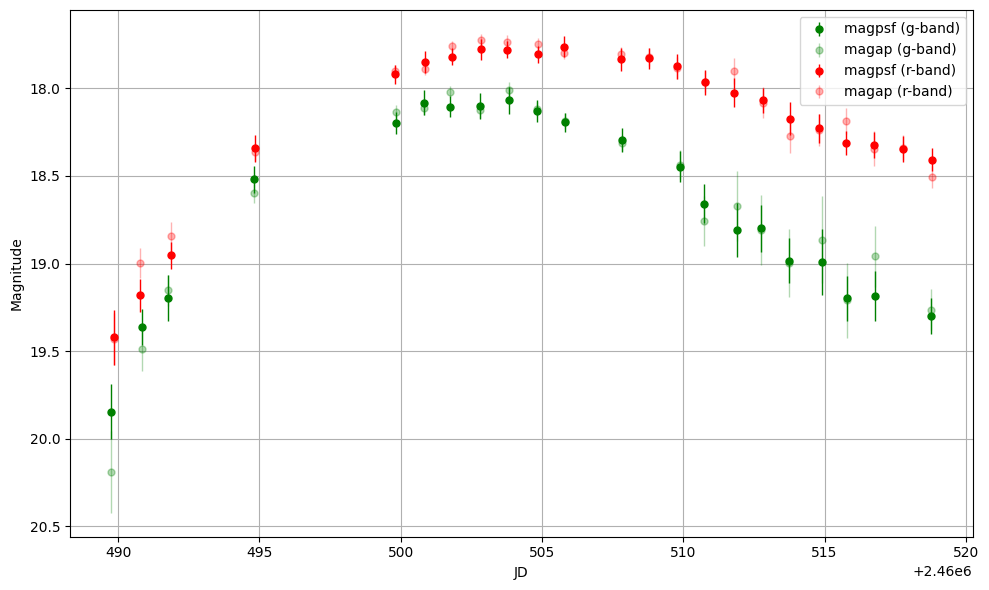

In [23]:
plot_ztf_prv_lightcurve(alert)

This is a supernova-like object!!

In this way, you can access and handle the ZTF public data if you download the zip file!

## Step 1-2: Summerizing Important Data

So far, we have reviewed a single ZTF alert, but the original dataset for one night typically contains $>10^4$ alerts, totaling several GB.

TTo make the analysis more efficient and save time, I have preprocessed and extracted key information from all alerts on 2024/Jul/27. Specifically, the following fields have been retained: `objectId`, `candid`, and `candidate`, and the processed dataset is saved as: `./output_day1/day1_ztf_alert_20240728_min.json`.

If you would like to try generating this file yourself, you can uncomment the code in the following cell.
Note that this step requires the full alert data to be downloaded in Cell [3].

In [25]:
# #10GB ~ 12min
# output_path = os.path.join(output_dir, "ztf_alert_20240728.json")

# alert_dir = './output_day1/ztf_alert_20240728'
# with open(output_path, "w") as outfile:
#     outfile.write("[\n")

#     first = True
#     for filename in os.listdir(alert_dir):
#         if not filename.endswith(".avro"):
#             continue

#         path = os.path.join(alert_dir, filename)
#         with open(path, 'rb') as f:
#             for alert in reader(f):
#                 # Remove image data and selected metadata
#                 for key in ['schemavsn', 'publisher', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference']:
#                     alert.pop(key, None)

#                 # Output as compact JSON
#                 if not first:
#                     outfile.write(",\n")
#                 json.dump(alert, outfile, separators=(",", ":"))  # ← no spaces, minimal size
#                 first = False

#     outfile.write("\n]\n")

In [ ]:
# input_path  = os.path.join(output_dir, "ztf_alert_20240728.json")
# output_path = os.path.join(output_dir, "day1_ztf_alert_20240728_min.json")

# with open(input_path, "r") as f:
#     alerts = json.load(f)

# # important keys
# keep_keys = ["objectId", "candid", "candidate"]  

# # filtering
# filtered_alerts = [
#     {k: alert[k] for k in keep_keys if k in alert}
#     for alert in alerts
# ]

# # output as json
# with open(output_path, "w") as f:
#     json.dump(filtered_alerts, f, separators=(",", ":")) # save as minimum size


Now let’s take a look at the full set of alerts from one night.
Load `day1_ztf_alert_20240728_min.json`! (here, we load it as pandas DataFrame)

In [28]:
alert_path = os.path.join(output_dir, "day1_ztf_alert_20240728_min.json")
with open(alert_path, "r") as f:
    alerts = json.load(f)

# flatten the nested JSON structure into a pandas DataFrame using `pd.json_normalize()`.
alerts = pd.json_normalize(alerts, sep='_')

In [29]:
alerts.head(10)

,objectId,candid,candidate_jd,candidate_fid,candidate_pid,candidate_diffmaglim,candidate_pdiffimfilename,candidate_programpi,candidate_programid,candidate_candid,...,candidate_zpmed,candidate_clrmed,candidate_clrrms,candidate_neargaia,candidate_neargaiabright,candidate_maggaia,candidate_maggaiabright,candidate_exptime,candidate_drb,candidate_drbversion
0,ZTF24aaxjpds,2765176644715015009,2.460520e+06,1,2765176644715,20.021643,ztf_20240728176435_000376_zg_c12_o_q4_scimrefd...,Kulkarni,1,2765176644715015009,...,26.230000,0.550,0.271189,30.067198,40.853199,19.635611,11.925939,30.0,0.999954,d6_m7
1,ZTF24aaxjpdr,2765176642815015014,2.460520e+06,1,2765176642815,19.971622,ztf_20240728176435_000376_zg_c08_o_q1_scimrefd...,Kulkarni,1,2765176642815015014,...,26.204000,0.549,0.258970,8.762628,61.982407,16.505520,11.165796,30.0,0.001429,d6_m7
2,ZTF24aaxjpdy,2765176644215015028,2.460520e+06,1,2765176644215,19.924879,ztf_20240728176435_000376_zg_c11_o_q3_scimrefd...,Kulkarni,1,2765176644215015028,...,26.261999,0.538,0.257140,32.531033,-999.000000,20.095955,-999.000000,30.0,0.999978,d6_m7
3,ZTF18acwyyzm,2765176644715010000,2.460520e+06,1,2765176644715,20.021643,ztf_20240728176435_000376_zg_c12_o_q4_scimrefd...,Kulkarni,1,2765176644715010000,...,26.230000,0.550,0.271189,0.138652,-999.000000,16.758579,-999.000000,30.0,1.000000,d6_m7
4,ZTF18acwzasa,2765176642815015005,2.460520e+06,1,2765176642815,19.971622,ztf_20240728176435_000376_zg_c08_o_q1_scimrefd...,Kulkarni,1,2765176642815015005,...,26.204000,0.549,0.258970,0.104818,-999.000000,14.324246,-999.000000,30.0,0.999949,d6_m7
5,ZTF24aaxjpdv,2765176643715015010,2.460520e+06,1,2765176643715,19.996626,ztf_20240728176435_000376_zg_c10_o_q2_scimrefd...,Kulkarni,1,2765176643715015010,...,26.160000,0.532,0.267746,15.611619,-999.000000,19.891186,-999.000000,30.0,0.000861,d6_m7
6,ZTF20aamdlcl,2765176646315010001,2.460520e+06,1,2765176646315,20.105875,ztf_20240728176435_000376_zg_c16_o_q4_scimrefd...,Kulkarni,1,2765176646315010001,...,26.163000,0.556,0.268253,0.289750,-999.000000,14.870197,-999.000000,30.0,0.999964,d6_m7
7,ZTF19adgyfem,2765176642815015002,2.460520e+06,1,2765176642815,19.971622,ztf_20240728176435_000376_zg_c08_o_q1_scimrefd...,Kulkarni,1,2765176642815015002,...,26.204000,0.549,0.258970,0.362904,22.590822,19.479500,12.522147,30.0,0.999213,d6_m7
8,ZTF18adpuxds,2765176642815010002,2.460520e+06,1,2765176642815,19.971622,ztf_20240728176435_000376_zg_c08_o_q1_scimrefd...,Kulkarni,1,2765176642815010002,...,26.204000,0.549,0.258970,0.513399,30.695732,15.980333,13.939219,30.0,1.000000,d6_m7
9,ZTF18acwyyuo,2765176644615010001,2.460520e+06,1,2765176644615,19.997782,ztf_20240728176435_000376_zg_c12_o_q3_scimrefd...,Kulkarni,1,2765176644615010001,...,26.212999,0.542,0.275775,0.133621,-999.000000,16.839851,-999.000000,30.0,1.000000,d6_m7


How many alerts are reported on 2024/Jul/28?

In [30]:
print(f"Total number of alerts on 20240728: {len(alerts)}")

Total number of alerts on 20240728: 218794


You can now see how many transients ZTF discovers and reports in every night!!

## Step 1-3: Visualizing the ZTF Alert and Statistics

We have now obtained all the alert data reported in a single night. Let’s take a look at some basic statistics of these alerts.

First, let’s plot the sky positions of the reported alerts.

`plot_alert_density(df, ra_col="candidate_ra", dec_col="candidate_dec", nbins=50, cmap="YlGn", title="ZTF alerts", log=False)`

Visualize the sky distribution of alerts using a Mollweide projection and a 2D RA/Dec histogram.

Arguments:
- `df` (pandas.DataFrame): DataFrame containing sky positions (RA and Dec) of ZTF alerts.
- `ra_col` (str): Name of the column containing Right Ascension in degrees (default: `"candidate_ra"`).
- `dec_col` (str): Name of the column containing Declination in degrees (default: `"candidate_dec"`).
- `nbins` (int): Number of bins for the RA and Dec histogram (default: 50).
- `cmap` (str): Colormap for the density map (default: `"YlGn"`).
- `title` (str): Title for the plot (default: `"ZTF alerts"`).
- `log` (bool): Whether to apply logarithmic scaling to the density map (default: `False`).

Returns:
- `None`: Displays a Mollweide projection plot showing the density of alerts on the sky (RA is wrapped to [-$\pi$, $\pi$]).

In [31]:
def plot_alert_density(df, ra_col="candidate_ra", dec_col="candidate_dec",
                        nbins=50, cmap="YlGn", title="ZTF alerts", log=False):

    # Extract RA and Dec values from the DataFrame and convert to SkyCoord
    ra = df[ra_col].values
    dec = df[dec_col].values
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

    # Convert RA to radians in the range [-pi, pi] for Mollweide projection
    ra_rad = np.remainder(coords.ra.radian + 2*np.pi, 2*np.pi)
    ra_rad[ra_rad > np.pi] -= 2*np.pi
    dec_rad = coords.dec.radian

    # Compute 2D histogram (RA vs. Dec) for number density
    H, xedges, yedges = np.histogram2d(ra_rad, dec_rad, bins=nbins)

    # Transpose and vertically flip for proper Mollweide orientation
    H = H.T[::-1, :]

    # Create a Mollweide projection figure
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection="mollweide")

    # Define plot boundaries
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Apply log scale if requested, mask zero values to avoid log(0)
    H_masked = np.where(H == 0, np.nan, H)
    if log:
        im = ax.imshow(
            H_masked,
            extent=extent,
            cmap=cmap,
            aspect="auto",
            interpolation="nearest",
            norm=LogNorm(vmin=1, vmax=H.max())
        )
    else:
        im = ax.imshow(
            H_masked,
            extent=extent,
            cmap=cmap,
            aspect="auto",
            interpolation="nearest",
            vmin=1
        )

    # Add title and grid
    ax.set_title(title)
    ax.grid(True)

    # Add colorbar to show density scale
    plt.colorbar(im, ax=ax, orientation="horizontal", label="Alert density", shrink=0.7, pad=0.07)
    plt.show()

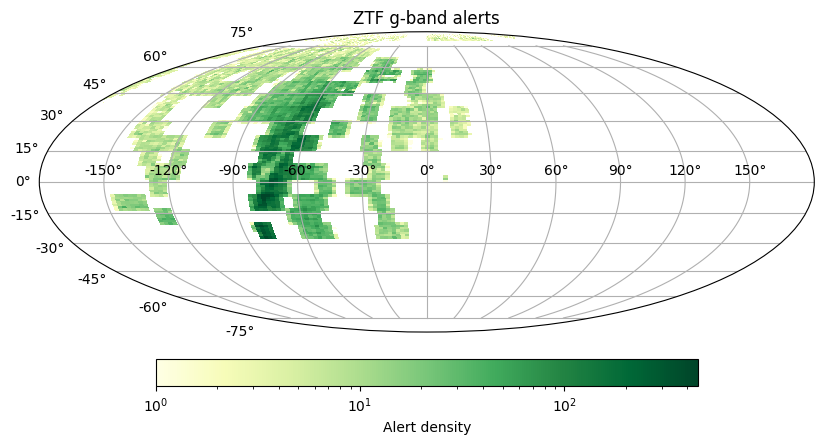

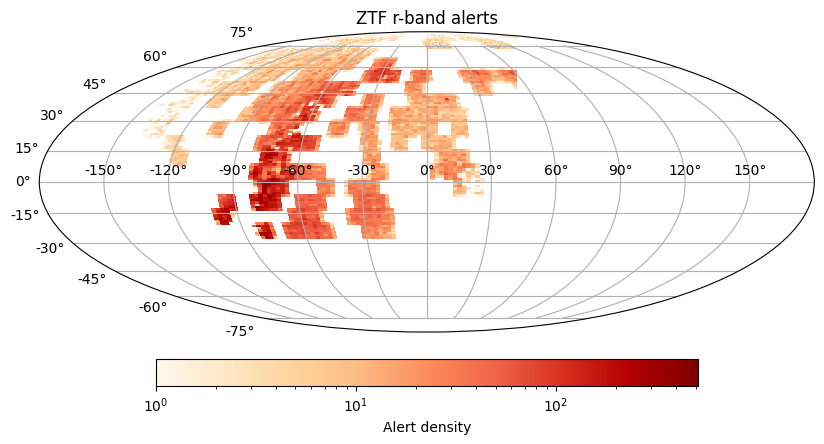

In [32]:
# separate the date into each band.
alert_g = alerts[(alerts["candidate_fid"] == 1)]
alert_r = alerts[(alerts["candidate_fid"] == 2)]

plot_alert_density(alert_g, nbins=100, cmap="YlGn", title="ZTF g-band alerts", log=True)
plot_alert_density(alert_r, nbins=100, cmap="OrRd", title="ZTF r-band alerts", log=True)

This will give you a sense of how wide an area ZTF observes in one night.

According to the official report, the ZTF limiting magnitude is approximately $\sim 20.5$ mag. You can check the statistical limiting magnitude for confirmation.

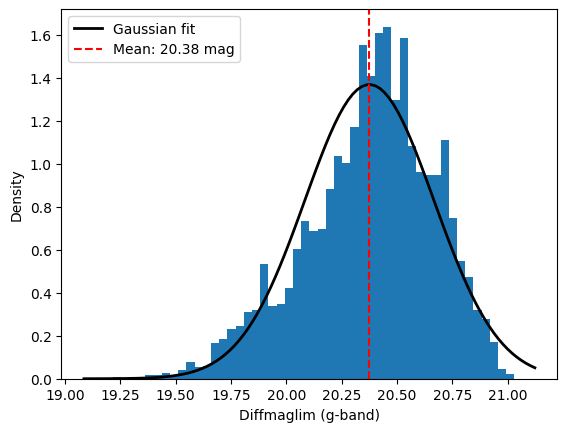

Mean limiting mag: 20.38 mag
Standard deviation: 0.29 mag


In [33]:
plt.hist(alert_g['candidate_diffmaglim'], bins=50, density=True)

# gaussian fitting
mu, std = norm.fit(alert_g['candidate_diffmaglim'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

# mean value
plt.axvline(mu, color='red', linestyle='--', label=f'Mean: {mu:.2f} mag')

plt.xlabel('Diffmaglim (g-band)')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"Mean limiting mag: {mu:.2f} mag")
print(f"Standard deviation: {std:.2f} mag")

This is consistent with the ZTF reports.
As an additional check, we also examine the FWHM, whose mean value is $\sim 2$ sec.

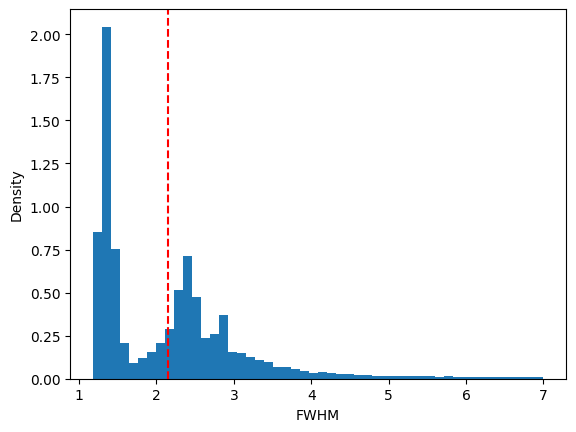

Mean FWHM: 2.1511800121392337


In [34]:
plt.hist(alert_g['candidate_fwhm'], bins=50, density=True)
plt.axvline(alert_g['candidate_fwhm'].mean(), linestyle='--', color='red')
plt.xlabel('FWHM')
plt.ylabel('Density')
plt.show()

print(f"Mean FWHM: {alert_g['candidate_fwhm'].mean()}")

---

# Step 2: Hunting Transients

In Step 1, we learned the basic structure of a ZTF alert.

The next step is to explore how we can search for transients of interest using the information provided in the alerts.

Fortunately, ZTF alerts include a variety of useful flags and quality indicators.
By utilizing these flags, we can begin filtering the alerts to identify real transients (e.g., supernovae, TDEs, AGN, ...).

Let’s try using these features to find candidates.

## Step 2-1: Select Possible SN-like Transients from the ZTF Alerts Observed on 20240728

`candidate` contains a number of informative flags and parameters that help assess the reliability and properties of the detection.

The most simple and strong flag is `drb`: Real–Bogus score (closer to 1 means more likely to be real).

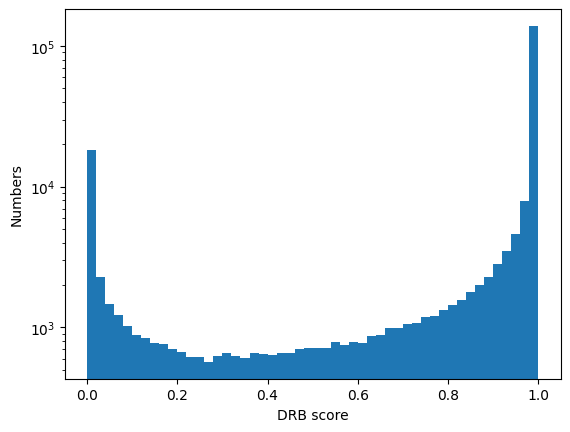

In [36]:
plt.hist(alerts['candidate_drb'], bins=50)
plt.xlabel('DRB score')
plt.ylabel('Numbers')
plt.yscale('log')
plt.show()

If the detections correspond to real objects, the flag value will be close to 1.
Here, we adopt a threshold of 0.9.

In [37]:
mask_drb = alerts['candidate_drb'] > 0.9
print(f"Alerts filtered by DRB: {mask_drb.sum()}")

Alerts filtered by DRB: 157711


---
---

## Assignment 1: Combine Flags to Filter SN-like Transients

Using `drb` flag alone, we filtered out 157,711 candidates from over 200,000 alerts.

In addition to the flags introduced here, ZTF alert data include many other useful flags.

Your task here is to design and apply your own set of filters to select SN-like transients! (Please look up the flag names and their meanings on your own.)

In [98]:
mask_ndethist = (alerts['candidate_ndethist'] < 50) & (alerts['candidate_ndethist'] > 5)
mask_distnspr1 = alerts['candidate_distpsnr1'] > 1
mask_sgscore1 = alerts['candidate_sgscore1'] < 0.3
mask_ssdistnr = alerts['candidate_ssdistnr'] < 0


---
---

In [106]:
mask_SN = (mask_drb & mask_ndethist & mask_ssdistnr & mask_sgscore1 & mask_distnspr1 & mask_jdstarthist)

SN = alerts[mask_SN]
SN.reset_index(inplace=True, drop=True)
print(f"Number of SN-like candidates: {len(SN)}")

Number of SN-like candidates: 102


If you set the filters appropriately, you should be able to narrow it down to $\sim 100$ objects.

Once you think you've narrowed down the sample appropriately, proceed to the next step! (We will return to this in Step 4.)

Let's plot the position of SN candidates

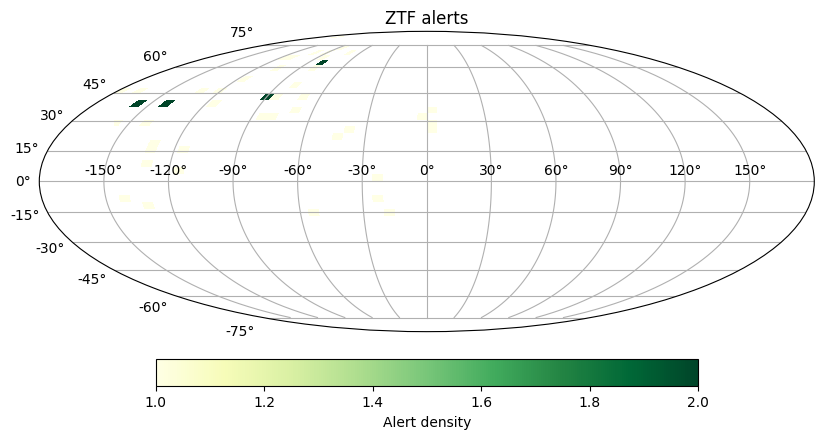

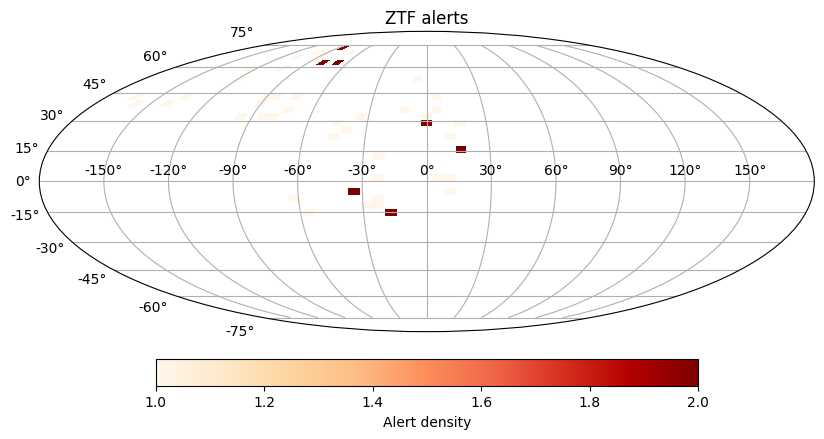

In [107]:
SN_g = SN[SN['candidate_fid']==1]
SN_r = SN[SN['candidate_fid']==2]

plot_alert_density(SN_g, nbins=30, cmap="YlGn")
plot_alert_density(SN_r, nbins=30, cmap="OrRd")

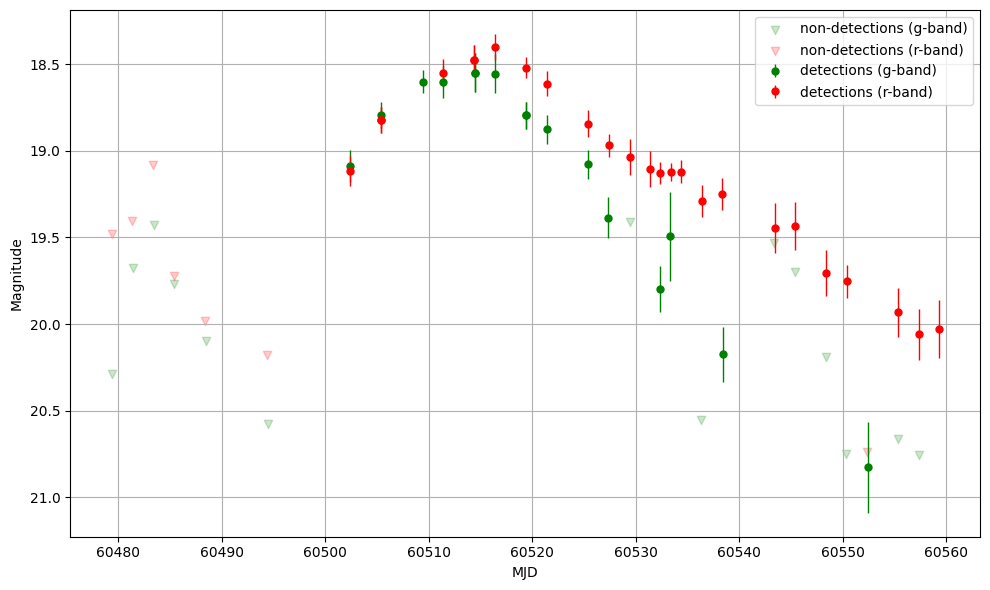

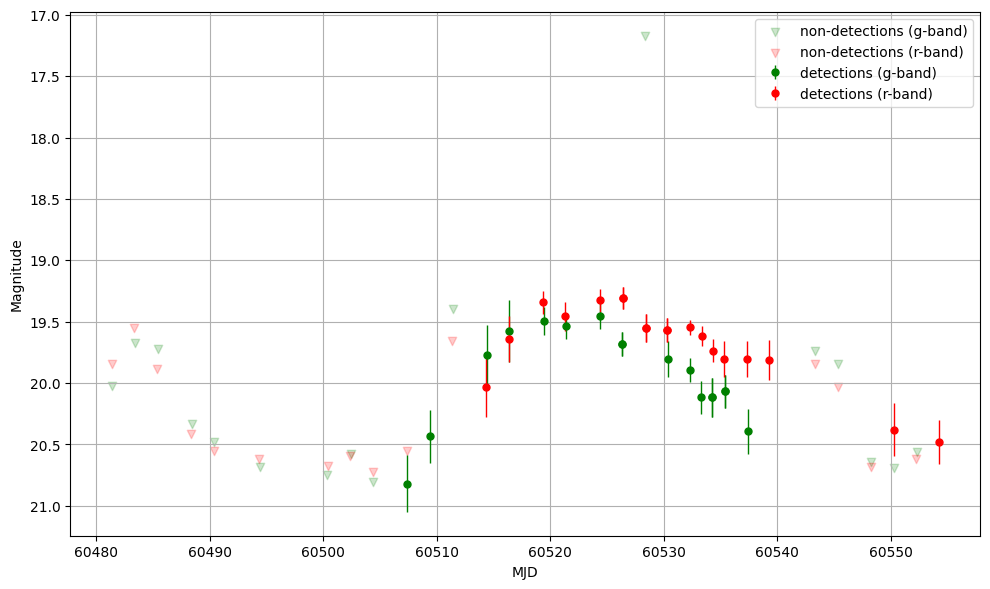

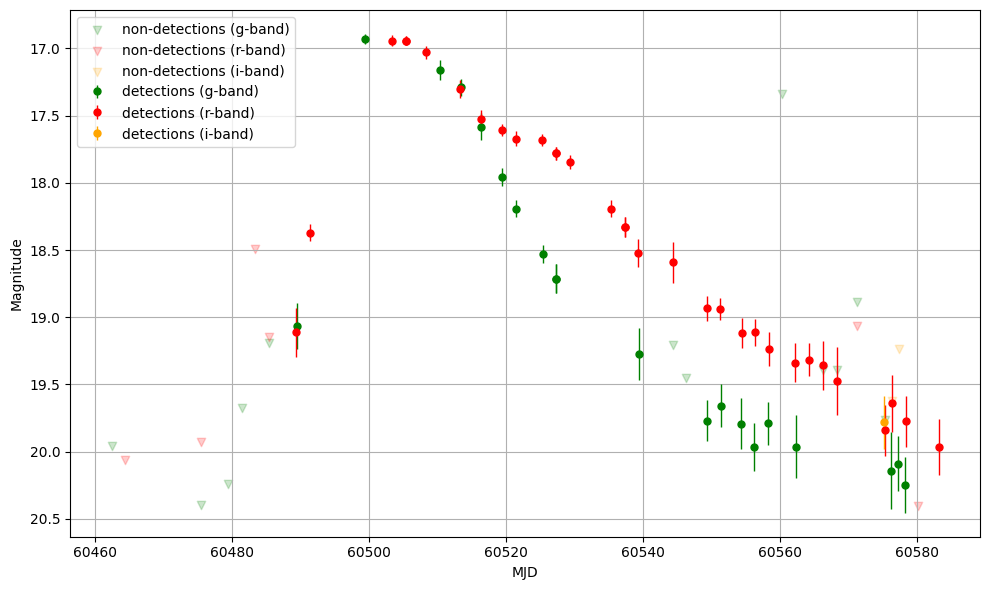

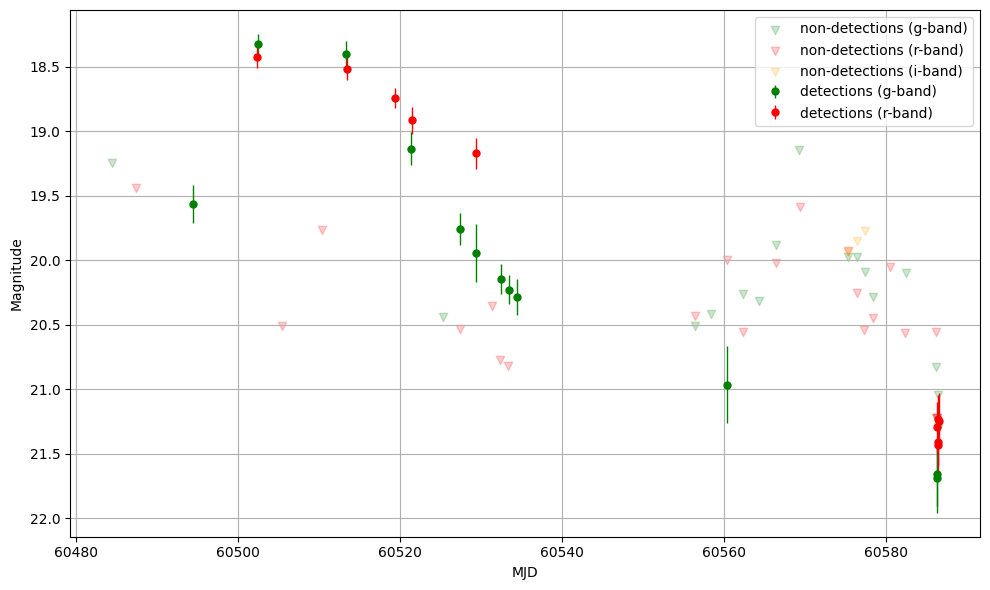

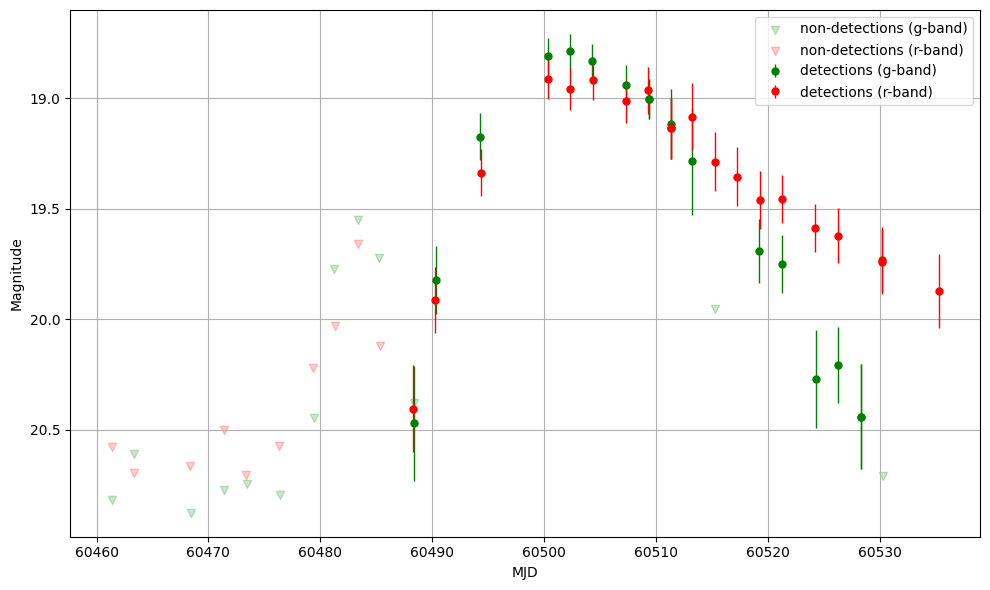

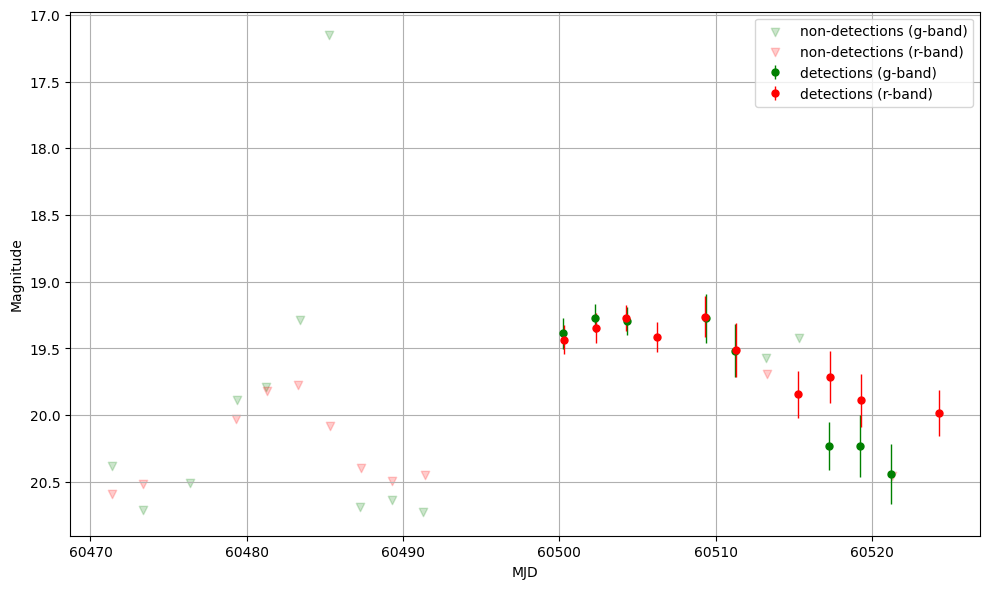

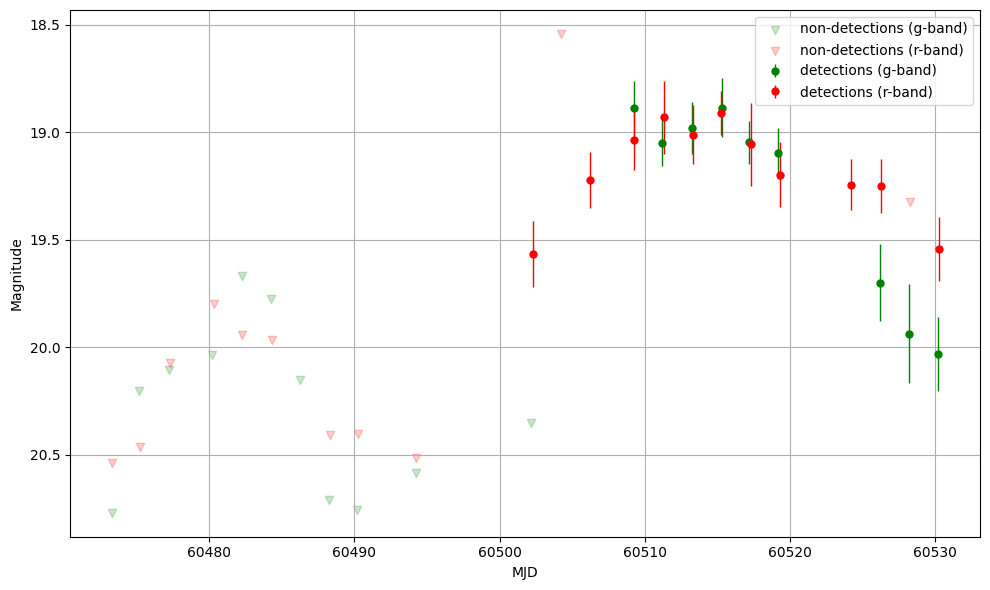

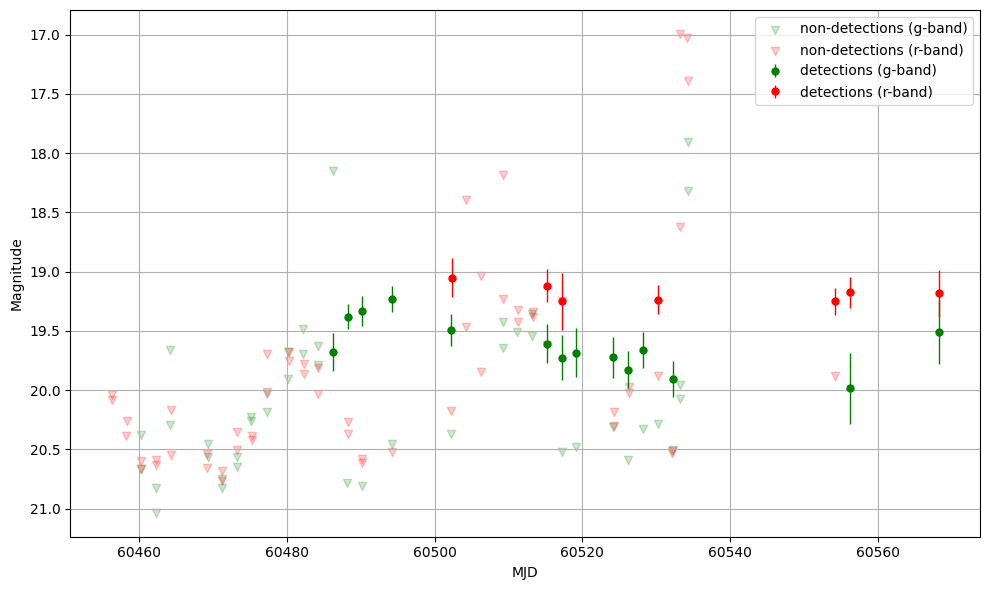

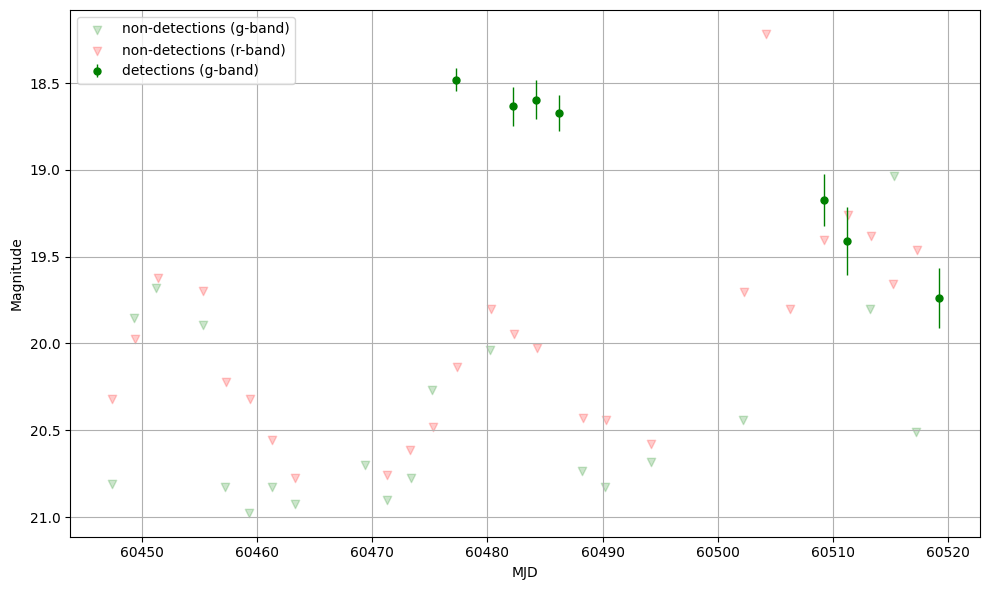

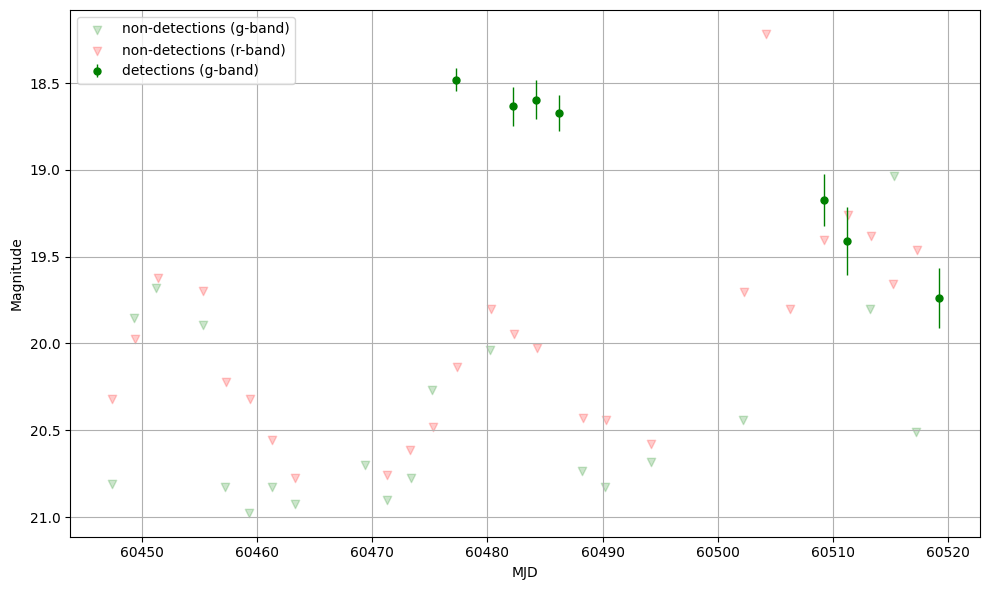

In [108]:
for i in [random.randint(1, len(SN)) for _ in range(10)]:
    lc_example = alerce.query_lightcurve(oid=SN['objectId'].to_list()[i], format="json")

    combined_data = {'detections': lc_example.get('detections', []),
                    'non_detections': lc_example.get('non_detections', []),
                    'forced_detections': []}

    plot_alerce_lightcurve(combined_data)

---

# Step3: Utilizing the ZTF Brokers

So far, we have worked with the ZTF public alerts directly.
However, as we have seen, handling raw public alerts can be challenging due to the large data volume and complex format.

To address this challenge, Brokers play an important role.
Brokers process and reformat alert data to make it more accessible and easier to use for the scientific community.

In this step, we will use a broker to dig deeper into the alerts we examined earlier, and learn how to leverage broker-added features for scientific analysis.

## ALeRCE

[ALeRCE (Automatic Learning for the Rapid Classification of Events)](https://alerce.science/) is a real-time broker which is processing the alert stream from ZTF and which aims to become a Community Broker for the LSST survey.

ALeRCE provides a lot of powerful infromation like:

- Cross-matches with external catalogs (e.g., Pan-STARRS, Gaia)
- Light curves
- light curve classification using machine learning
- **Public APIs for query and data access**

Indeed, there are several brokers such as [Fink](https://fink-portal.org/ZTF) or [Lasair](https://lasair-ztf.lsst.ac.uk/), but they are not completely public.

So, hereafter, let's use the ALeRCE.

ALeRCE has already prepared several important tasks as API (see [Link](https://alerce.readthedocs.io/en/latest/)).

Let's try several basic task of ALeRCE API !

## Step 3-1: Try `query_objects`

One of the main features of the ALeRCE API is the query_objects method.

This method allows you to retrieve metadata about a ZTF object, such as its ZTF name, RA, Dec, and more.

But the most interesting part is that ALeRCE also provides machine learning-based classification results for each object.

For example, querying an object can be done as follows:

In [109]:
# Example
mjd_start = Time("2024-01-01T00:00:00", format="isot", scale="utc").mjd

QUERY_KW = {'classifier': "LC_classifier_ATAT_forced_phot(beta)", # classifer name
            "probability": 0.9, # lower limit of the estimated probability
            "ndet": 10, # minimum detection number
            "firstmjd": mjd_start, # servey range
            "page_size": 1000, # maximum number of objects
            "format": "pandas" # data format
            }
query_table = alerce.query_objects(**QUERY_KW)

In [110]:
query_table.head(10)

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF24abtczty,99,2296,60634.407292,60743.241759,False,False,27,None,None,...,60743.241759,107.995116,94.504676,78.367089,0.062037,0.012509,SNII,LC_classifier_ATAT_forced_phot(beta),0.970212,26.0.1
1,ZTF19adnsjwg,107,399,58233.210741,60815.189606,True,False,43,None,None,...,60815.189606,380.912847,176.388673,-23.239333,0.011800,0.010842,RSCVn,LC_classifier_ATAT_forced_phot(beta),0.923387,27.5.6
2,ZTF25aaataoj,404,972,58607.296875,60836.184271,True,False,37,None,None,...,60836.184271,174.682153,190.638534,-19.538989,0.012111,0.011414,RSCVn,LC_classifier_ATAT_forced_phot(beta),0.976187,27.5.6
3,ZTF24aaqnrgo,149,4296,58487.496053,60859.349317,True,False,64,None,None,...,60859.349317,393.142928,248.894979,62.714349,0.019070,0.008742,QSO,LC_classifier_ATAT_forced_phot(beta),0.982513,27.5.6
4,ZTF25aallhpj,50,975,60759.346204,60823.232778,False,False,21,None,None,...,60823.232778,61.856030,209.372104,-10.567508,0.016740,0.016456,SNIa,LC_classifier_ATAT_forced_phot(beta),0.964868,27.5.6
5,ZTF25aabsqjr,1054,2545,58232.460995,60717.454514,True,False,27,None,None,...,60717.454514,57.883600,246.314660,8.815378,0.015384,0.015203,LPV,LC_classifier_ATAT_forced_phot(beta),0.984673,26.0.1
6,ZTF24aaqverf,39,4785,58911.494873,60787.371030,True,False,11,None,None,...,60787.371030,337.943866,243.549633,33.647971,0.025001,0.020812,RSCVn,LC_classifier_ATAT_forced_phot(beta),0.938700,26.0.1
7,ZTF24abyhmnl,58,822,60663.556146,60823.246551,False,False,24,None,None,...,60823.246551,166.678287,221.063110,-20.337460,0.018504,0.017351,SNII,LC_classifier_ATAT_forced_phot(beta),0.931150,27.5.6
8,ZTF24abzarxy,933,1851,58255.404688,60762.447604,True,False,17,None,None,...,60762.447604,123.310972,297.423766,52.290258,0.029648,0.018134,LPV,LC_classifier_ATAT_forced_phot(beta),0.981610,26.0.1
9,ZTF21aazbhdt,156,870,58936.460197,60858.321181,True,False,38,None,None,...,60858.321181,546.794641,222.556198,15.532614,0.012648,0.012186,QSO,LC_classifier_ATAT_forced_phot(beta),0.942526,27.5.6


What date is stored in?

In [111]:
query_table.columns

Index(['oid', 'ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist',
       'corrected', 'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'firstmjd', 'lastmjd', 'deltajd', 'meanra', 'meandec',
       'sigmara', 'sigmadec', 'class', 'classifier', 'probability',
       'step_id_corr'],
      dtype='object')

In particular, `class`, `classifier`, and `probability` are unique to ALeRCE.
By using this information, we can quickly identify interesting objects.

As a test, let's visualize a fraction of each `class`.

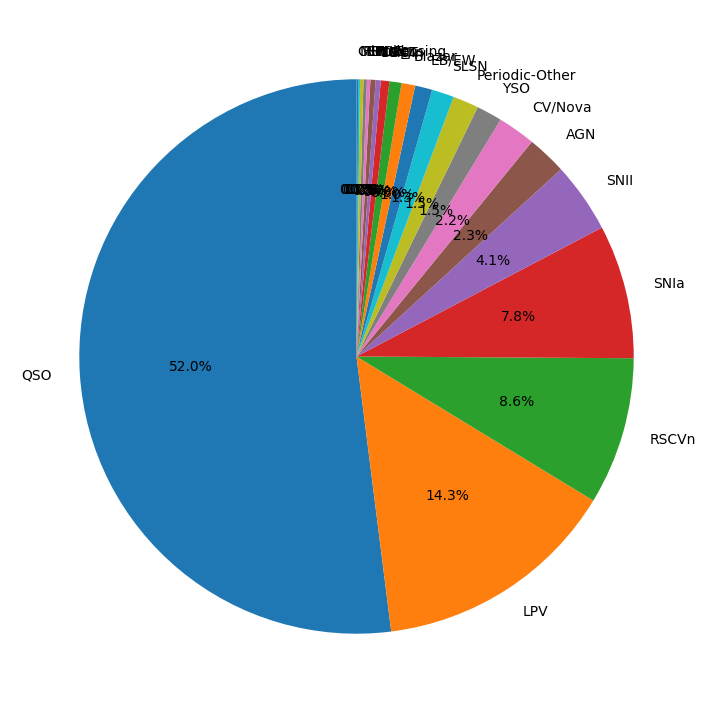

In [112]:
fig, ax = plt.subplots(figsize = (12,9))
class_counts = query_table['class'].value_counts()
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)
plt.show()

Enlerge the small populations.

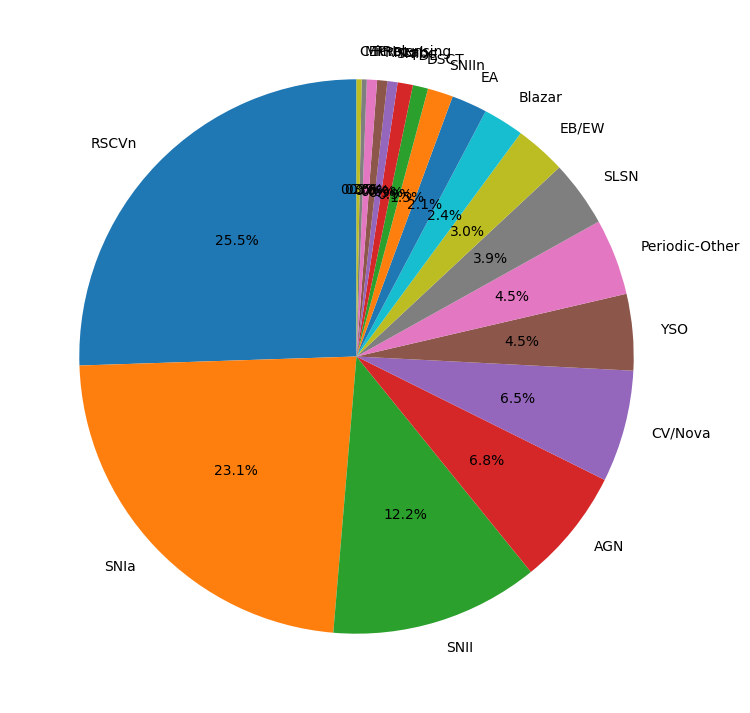

In [113]:
# show the fractions of each class
fig, ax = plt.subplots(figsize = (12,9))
query_table_wo_QSO_LPV = query_table[(query_table['class'] != 'QSO') & (query_table['class'] != 'LPV')]
class_counts = query_table_wo_QSO_LPV['class'].value_counts()
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)
plt.show()

ALeRCE equipped several classifer (see `./alerce_classifier.json`). It is interesting to change the method and check the results (homework).

## Step 3-2: Try `query_lightcurve`

Another important feature of the ALeRCE API is `query_lightcurve`.

This method returns the light curve of a given object, including both detections and non-detection points, similar to `prv_candidates` in the public ZTF alerts.

You can retrieve a light curve easily by searching with the ZTF object name.

In [114]:
# Example
ztf_name = 'ZTF23aaklqou'
lc_example = alerce.query_lightcurve(oid=ztf_name, format="json")

What is stored in?

In [115]:
lc_example['detections'][0]

{'tid': 'ztf',
 'mjd': 60083.32299769996,
 'candid': '2329322992515015018',
 'fid': 1,
 'pid': 2329322992515,
 'diffmaglim': 20.908613,
 'isdiffpos': 1,
 'nid': 2329,
 'distnr': 3.862503,
 'magpsf': 15.904906,
 'magpsf_corr': None,
 'magpsf_corr_ext': None,
 'magap': 15.9089,
 'magap_corr': None,
 'sigmapsf': 0.0290031,
 'sigmapsf_corr': None,
 'sigmapsf_corr_ext': None,
 'sigmagap': 0.0067,
 'sigmagap_corr': None,
 'ra': 210.9106833,
 'dec': 54.3116718,
 'rb': 0.8642857,
 'rbversion': 't17_f5_c3',
 'drb': 0.9983937,
 'magapbig': 15.9068,
 'sigmagapbig': 0.0077,
 'rfid': 792120125,
 'has_stamp': True,
 'corrected': False,
 'dubious': False,
 'candid_alert': None,
 'step_id_corr': '1.2.0',
 'phase': 0.0,
 'parent_candid': None}

In [116]:
lc_example['non_detections'][0]

{'tid': 'ztf', 'mjd': 60055.293252300005, 'fid': 1, 'diffmaglim': 20.3822}

- `detections`: similar format of `'prv_candidates'`
- `non_detections`: only include `mjd`, `fid`, and `diffmaglim`

Futhermore, they have a similar function of `query_forced_photometry` to access the forced photometries of an object.

In [117]:
fp_example = alerce.query_forced_photometry(oid=ztf_name, format="json")
fp_example[0]

{'candid': 'ZTF23aaklqou3096363132515',
 'tid': 'ztf',
 'pid': 3096363132515,
 'oid': 'ZTF23aaklqou',
 'mjd': 60850.36313659977,
 'fid': 2,
 'ra': 210.9107942,
 'e_ra': None,
 'dec': 54.3116102,
 'e_dec': None,
 'mag': 19.638059616088867,
 'e_mag': 0.10025878995656967,
 'mag_corr': None,
 'e_mag_corr': None,
 'e_mag_corr_ext': None,
 'isdiffpos': 1,
 'corrected': False,
 'dubious': False,
 'parent_candid': 3105230162515015013,
 'has_stamp': False,
 'scibckgnd': 157.8780059814453,
 'exptime': 30.0,
 'magnr': 20.53700065612793,
 'scisigpix': 7.988399982452393,
 'adpctdif1': 0.1273680031299591,
 'sigmagnr': 0.14000000059604645,
 'magzpsci': 26.190399169921875,
 'adpctdif2': 0.12045899778604507,
 'chinr': 3.177000045776367,
 'diffmaglim': 20.246700286865234,
 'programid': 1,
 'sharpnr': 0.5180000066757202,
 'field': 792,
 'magzpsciunc': 2.62533994828118e-05,
 'procstatus': '0',
 'rcid': 25,
 'magzpscirms': 0.03240180015563965,
 'distnr': 4.803852558135986,
 'rfid': 792120225,
 'clrcoeff': 

For the next step, store the queried light curve data as one dict style.

In [118]:
combined_data = {'detections': lc_example.get('detections', []),
                 'non_detections': lc_example.get('non_detections', []),
                 'forced_detections': fp_example if isinstance(fp_example, list) else []}

Let's plot the queried light curve!!

`plot_alerce_lightcurve(data_json, plot_detections=True, plot_non_detections=True, plot_forced_detections=False, mjd_range=None)`

Plot the light curve from an ALeRCE-style alert JSON dictionary, including both detections and non-detections across available filters.

Arguments:
- `data_json (dict)`: ALeRCE lightcurve JSON data.
  - `plot_detections (bool)`: Whether to plot normal detections.
  - `plot_non_detections (bool)`: Whether to plot non-detections.
  - `plot_forced_detections (bool)`: Whether to plot forced photometry points.
  - `mjd_range (tuple)`: Optional (min, max) range for MJD x-axis.

Returns:
- `None`: Displays a Matplotlib light curve with magnitude vs. MJD.

In [132]:
def plot_alerce_lightcurve(data_json, 
                           plot_detections=True, plot_non_detections=True, plot_forced_detections=False, 
                           mjd_range=None):

    if plot_detections:
        detections = data_json.get('detections', [])
    if plot_non_detections:
        non_detections = data_json.get('non_detections', [])
    if plot_forced_detections:
        forced_detections = data_json.get('forced_detections', [])

    # Filter ID mappings: fid = 1 (g), 2 (r), 3 (i)
    band_colors = {1: 'green', 2: 'red', 3: 'orange'}
    band_labels = {1: 'g-band', 2: 'r-band', 3: 'i-band'}

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title(data_json.get('objectId', 'Light Curve'))
    # --- Plot standard detections ---
    if plot_detections and len(detections) > 0:
        for fid in sorted(set(d['fid'] for d in detections if 'fid' in d)):
            band_data = [
                d for d in detections
                if d.get('fid') == fid and 'magpsf' in d and 'sigmapsf' in d
            ]
            if not band_data:
                continue

            mjd = [d['mjd'] for d in band_data]
            mag = [d['magpsf'] for d in band_data]
            err = [d['sigmapsf'] for d in band_data]

            ax.errorbar(
                mjd, mag, yerr=err,
                fmt='o', color=band_colors.get(fid, 'gray'),
                label=f'detections ({band_labels.get(fid, f"band {fid}")})',
                markersize=5, linewidth=1
            )

    # --- Plot non-detections ---
    if plot_non_detections and len(non_detections) > 0:
        for fid in sorted(set(d['fid'] for d in non_detections if 'fid' in d and 'diffmaglim' in d)):
            band_data = [
                d for d in non_detections
                if d['fid'] == fid and 'diffmaglim' in d
            ]
            mjd = [d['mjd'] for d in band_data]
            mag = [d['diffmaglim'] for d in band_data]

            ax.scatter(
                mjd, mag,
                marker='v', color=band_colors.get(fid, 'gray'),
                alpha=0.2,
                label=f'non-detections ({band_labels.get(fid, f"band {fid}")})'
            )

    # --- Plot forced photometry points ---
    if plot_forced_detections and len(forced_detections) > 0:
        for fid in sorted(set(d['fid'] for d in forced_detections if 'fid' in d)):
            band_data = [
                d for d in forced_detections
                if d.get('fid') == fid and 'mag' in d and 'e_mag' in d
            ]
            if not band_data:
                continue

            mjd = [d['mjd'] for d in band_data]
            mag = [d['mag'] for d in band_data]
            err = [d['e_mag'] for d in band_data]

            ax.errorbar(
                mjd, mag, yerr=err,
                fmt='s', color=band_colors.get(fid, 'gray'),
                label=f'forced ({band_labels.get(fid, f"band {fid}")})',
                markersize=5, linewidth=1, mfc='none'  # hollow square
            )

    # --- Plot formatting ---
    ax.invert_yaxis()
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    if mjd_range is not None:
        ax.set_xlim(left=mjd_range[0], right=mjd_range[1])
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


Plot `detections` and `non_detections`

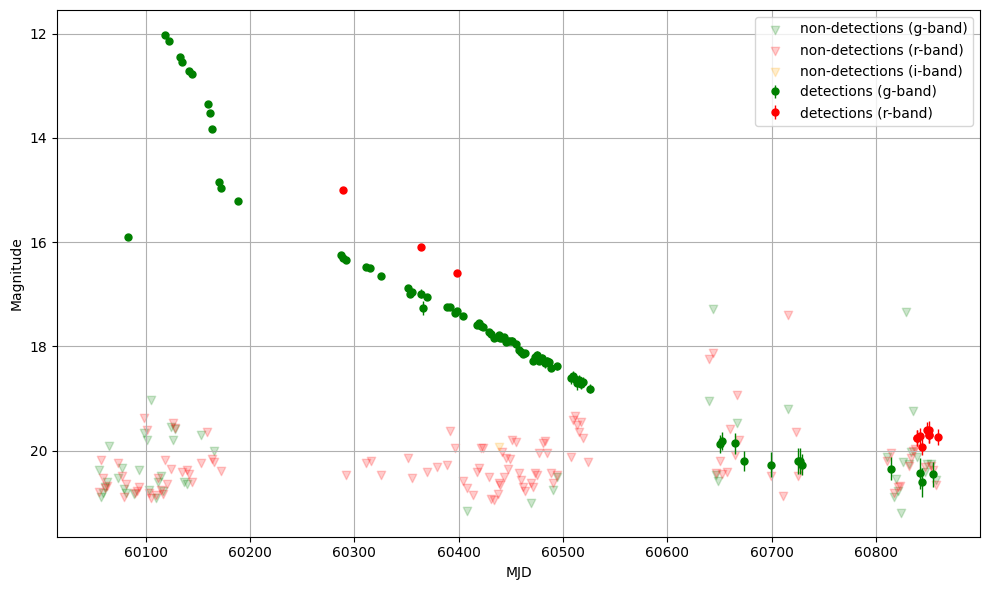

In [120]:
plot_alerce_lightcurve(combined_data)

Including the forced photometry data

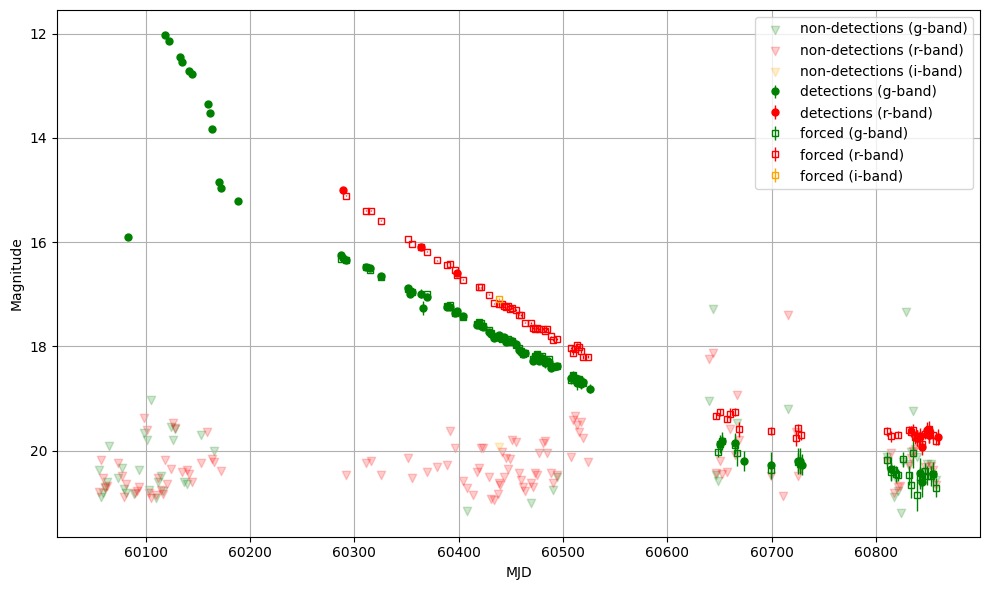

In [121]:
plot_alerce_lightcurve(combined_data, plot_forced_detections=True)

Using ALeRCE, we can easily access and handle the ZTF light curve data!

---

# Step 4: Combining between the ZTF Alerts and Brokers

We filtered SN-like transients in Step 2.
Let's check whether the selection worked well by examining their light curves using ALeRCE!

## Step 4-1: Query several light curves selected in Step2, and plot the light curve

Let's plot the selected light curves.
If our selection criteria are appropriate, the resulting light curves should resemble those of SN-like transients.

Randomly sample a ZTF name from the filtered alerts and plot its light curve.

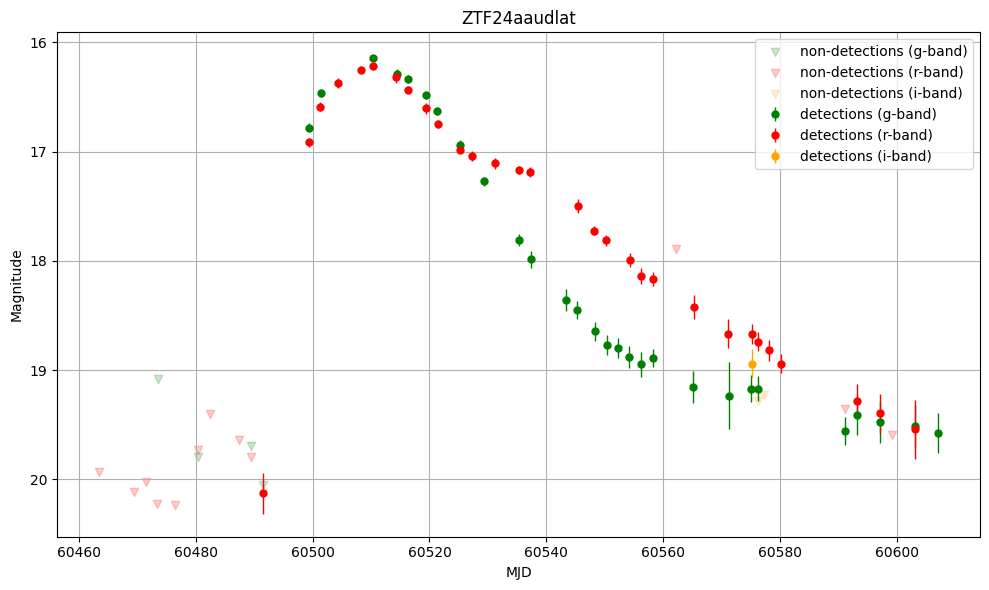

In [137]:
ztf_name = SN_g['objectId'].sample(1).iloc[0] 
lc_example = alerce.query_lightcurve(oid=ztf_name, format="json")
fp_example = alerce.query_forced_photometry(oid=ztf_name, format="json")

combined_data = {
    'detections': lc_example.get('detections', []),
    'non_detections': lc_example.get('non_detections', []),
    'forced_detections': fp_example if isinstance(fp_example, list) else [],
    'objectId': ztf_name
}

plot_alerce_lightcurve(combined_data)

---
---

## Assignment 2: Review Your Selected Sample from Step 2 and Refine the Criteria
Did you see any supernova-like light curves?
If you try plotting several times and no SN-like light curve appears, it likely means that your filtering conditions in Step 2 are not working well.
In that case, go back to Step 2, revise your selection criteria, and continue filtering until you can obtain satisfactory SN-like light curves.
If the selection appears to be working well, proceed to the next step.

---
---

---

# Step 5: Query the ALeRCE Light Curve Using the Aelected ZTF ID

If your selection looks appropriate, you can now query the corresponding ALeRCE light curves and save them to: `./output_day1/lc_alerce/`.

**Note: This process may take several minutes to complete, so it is recommended to limit the number of objects to fewer than 100.**

In [125]:
lc_dir = os.path.join(output_dir, "lc_alerce")
os.makedirs(lc_dir, exist_ok=True)

`fetch_alerce_lightcurves(oids, output_dir, max_retries=3, sleep_time=1.0, retry_wait=2.0, return_errors=False)`

Fetch lightcurve and forced photometry data from ALeRCE API and save to JSON files.

Arguments
- `oids (list of str)`: List of ZTF object IDs (e.g., ['ZTF23abc...', ...]).
- `output_dir (str)`: Directory where JSON files will be saved.
- `max_retries (int, optional)`: Number of retry attempts per object on failure (default: 3).
- `sleep_time (float, optional)`: Seconds to wait between API calls (default: 1.0).
- `retry_wait (float, optional)`: Seconds to wait between retries on failure (default: 2.0).
- `return_errors (bool)`: flag to save the list of fetching errors.

Returns
- `list`: List of object IDs that failed to fetch after retries.

In [126]:
def fetch_alerce_lightcurves(oids, output_dir, max_retries=3, sleep_time=1.0, retry_wait=2.0, return_errors=False):

    fetching_errors = []

    for i, oid in enumerate(oids, 1):
        print(f"[{i}/{len(oids)}] Fetching: {oid}")
        
        retries = 0
        success = False

        while retries < max_retries:
            try:
                # Query lightcurve
                lc = alerce.query_lightcurve(oid=oid, format="json")
                detections = lc.get("detections", [])
                non_detections = lc.get("non_detections", [])

                # Query forced photometry
                fp = alerce.query_forced_photometry(oid=oid, format="json")
                forced_detections = fp if isinstance(fp, list) else []

                # Combine into one dictionary
                combined_data = {
                    "detections": detections,
                    "non_detections": non_detections,
                    "forced_detections": forced_detections,
                }

                # Save to file
                output_path = os.path.join(output_dir, f"{oid}.json")
                with open(output_path, "w") as f:
                    json.dump(combined_data, f, indent=2)

                success = True
                break  # success, exit retry loop

            except Exception as e:
                print(f"Error fetching {oid} (attempt {retries + 1}): {e}")
                retries += 1
                time.sleep(retry_wait)

        if not success:
            fetching_errors.append(oid)

        time.sleep(sleep_time)

    print("Done.")
    
    if return_errors:
        return fetching_errors
    else:
        return

Let's query!

In [127]:
# Get OIDs
oids_to_query = [oid for oid in SN_g["objectId"]]

# ~5min for ~50 objects
fetch_alerce_lightcurves(oids=oids_to_query, output_dir=lc_dir)

[1/44] Fetching: ZTF24aatzgha
[2/44] Fetching: ZTF24aawlrhg
[3/44] Fetching: ZTF24aatzgua
[4/44] Fetching: ZTF24aaotlsk
[5/44] Fetching: ZTF24aavdccv
[6/44] Fetching: ZTF24aaulmfi
[7/44] Fetching: ZTF24aatchxo
[8/44] Fetching: ZTF24aaqgdpu
[9/44] Fetching: ZTF24aavexih
[10/44] Fetching: ZTF24aauuert
[11/44] Fetching: ZTF24aawxtxh
[12/44] Fetching: ZTF24aavozxo
[13/44] Fetching: ZTF24aawokhs
[14/44] Fetching: ZTF24aavpazc
[15/44] Fetching: ZTF24aawxnpl
[16/44] Fetching: ZTF24aawivmh
[17/44] Fetching: ZTF24aavydau
[18/44] Fetching: ZTF24aatjphv
[19/44] Fetching: ZTF24aawyjpo
[20/44] Fetching: ZTF24aaupnbu
[21/44] Fetching: ZTF24aavvuag
[22/44] Fetching: ZTF24aawshuy
[23/44] Fetching: ZTF24aatsiox
[24/44] Fetching: ZTF24aavbrtq
[25/44] Fetching: ZTF24aawkdym
[26/44] Fetching: ZTF24aawupfz
[27/44] Fetching: ZTF24aatqmcz
[28/44] Fetching: ZTF24aavukbc
[29/44] Fetching: ZTF24aaqzycc
[30/44] Fetching: ZTF24aavzwkd
[31/44] Fetching: ZTF24aatwwpj
[32/44] Fetching: ZTF24aavzchn
[33/44] Fetching:

---

# Step 6: Mock Observation with LSST

Now, let's perform a mock observation, simulating how LSST would observe the selected objects.

The LSST has a significantly deeper limiting magnitude than ZTF; $\sim 100$ times fainter. However, it also has a longer cadence, typically $\sim 5$-day baseline.

If LSST were observing the same objects detected by ZTF, what would their light curves look like?

In this step, we will focus on the g- and r-band light curves, and simulate how LSST might observe them based on its depth and cadence.

---
---

## Assignment 3: Select One Light Curve from Step 5 and Simulate LSST Observations

In this assignment, you will select one of the light curves obtained in Step 5 and simulate how it would appear if observed by LSST.

We will downsample the ZTF light curve to match the approximate LSST cadence (~5 days).
For simplicity, we will neglect the difference in filter transmission between ZTF and LSST filters (this will be addressed in tomorrow’s exercise).

Then, we will examine how the light curve would look when observed with LSST's deeper limiting magnitudes.

To Do:
1. Select one light curve obtained in Step 5
2. Interpolate the g- and r-band light curves separately
3. Downsample the interpolated light curves to match a 5-day cadence (if possible, let's try to use Rubin-sim module (https://rubin-sim.lsst.io/index.html), which provide more robust cadenses.)
4. Plot the resulting light curves, masking any data fainter than LSST’s limiting magnitudes

You can use the helper functions we’ve already defined.

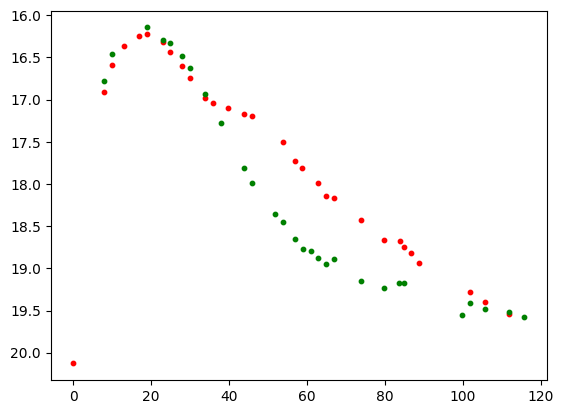

In [154]:
## YOUR CODE HERE

with open(os.path.join(lc_dir, f"ZTF24aaudlat.json"), "r") as f:
    combined_data = json.load(f)
    
# plot_alerce_lightcurve(combined_data)

r_mjd = np.array([det['mjd'] for det in combined_data['detections'] if det['fid'] == 2])
r_magpsf = np.array([det['magpsf'] for det in combined_data['detections'] if det['fid'] == 2])

g_mjd = np.array([det['mjd'] for det in combined_data['detections'] if det['fid'] == 1])
g_magpsf = np.array([det['magpsf'] for det in combined_data['detections'] if det['fid'] == 1])

r_t = r_mjd - min(r_mjd)
g_t = g_mjd - min(r_mjd)

plt.scatter(r_t, r_magpsf, color='red', label='r-band detections', s=10)
plt.scatter(g_t, g_magpsf, color='green', label='r-band detections', s=10)
plt.gca().invert_yaxis()


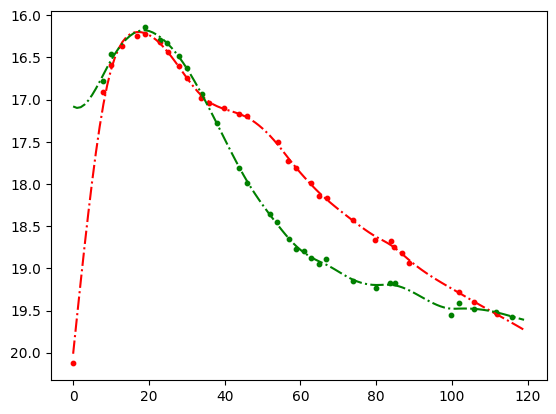

In [259]:
from scipy.interpolate import make_smoothing_spline

tnew = np.arange(0, 120)

r_spl = make_smoothing_spline(r_t, r_magpsf, lam=20)
g_spl = make_smoothing_spline(g_t, g_magpsf, lam=20)

plt.scatter(r_t, r_magpsf, color='red', label='r-band detections', s=10)
plt.scatter(g_t, g_magpsf, color='green', label='r-band detections', s=10)
plt.plot(tnew, r_spl(tnew), 'r-.')
plt.plot(tnew, g_spl(tnew), 'g-.')

plt.gca().invert_yaxis()

In [261]:
r_slope = (r_spl(80) - r_spl(100)) / 20
g_slope = (g_spl(82) - g_spl(102)) / 20

def sn_lc_r(times):
    return [r_spl(t) if t < 90 else r_spl(90) - r_slope * (t - 90) for t in times]
    
def sn_lc_g(times):
    return [g_spl(t) if t < 90 else g_spl(90) - g_slope * (t - 90) for t in times]

print(g_slope)


-0.014121696373950244


In [272]:
candence = 12
maxt = 360
t_lsst = np.arange(random.randint(0, 5), maxt, candence)

lsst_r_magpsf = sn_lc_r(t_lsst)
lsst_g_magpsf = sn_lc_g(t_lsst)


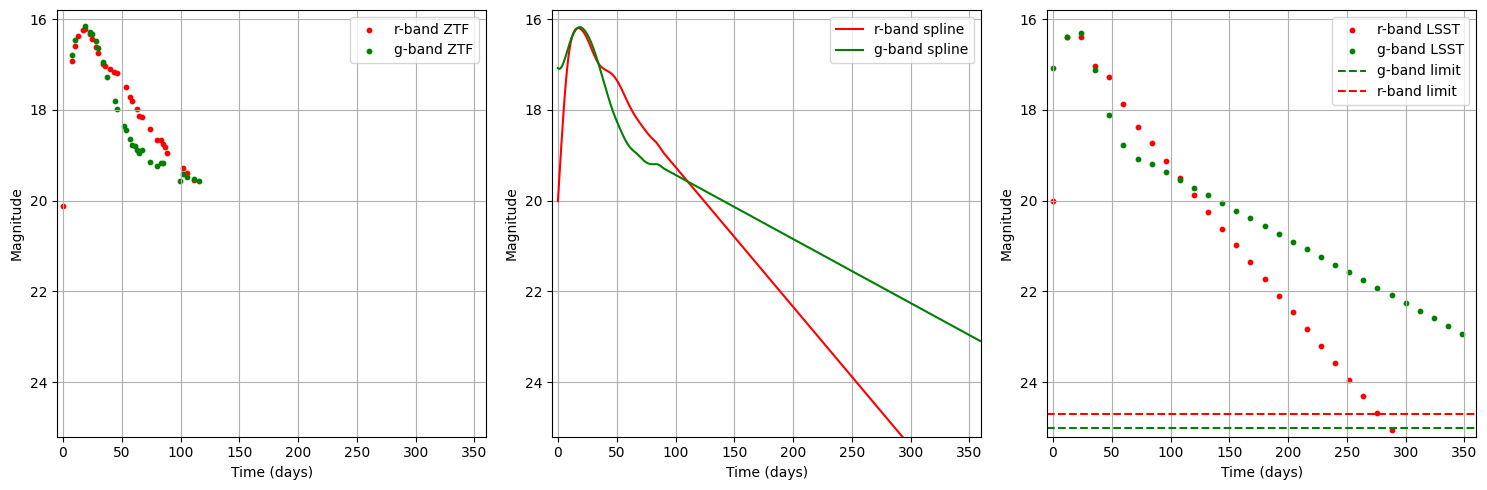

In [274]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(r_t, r_magpsf, color='red', label='r-band ZTF', s=10)
axs[0].scatter(g_t, g_magpsf, color='green', label='g-band ZTF', s=10)

tnew = np.arange(0, maxt)
axs[1].plot(tnew, sn_lc_r(tnew), 'r-', label='r-band spline')
axs[1].plot(tnew, sn_lc_g(tnew), 'g-', label='g-band spline')

axs[2].scatter(t_lsst, lsst_r_magpsf, color='red', label='r-band LSST', s=10)
axs[2].scatter(t_lsst, lsst_g_magpsf, color='green', label='g-band LSST', s=10)

axs[2].axhline(y=25, c='g', linestyle='--', label='g-band limit')
axs[2].axhline(y=24.7, c='r', linestyle='--', label='r-band limit')

for ax in axs:
    ax.legend()
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Magnitude")
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_xlim(-5, maxt)
    ax.set_ylim(25.2, 15.8)
    
plt.tight_layout()
plt.show()

---
---

---

# Discussions and Further Steps:

Today, we worked on handling ZTF alerts and using ALeRCE broker data.

If you have extra time, consider exploring the following points:
- Try changing the selection criteria in Step 2 to extract different types of objects — such as variable stars, AGNs, tidal disruption events (TDEs), or fast transients.
- Get more familiar with the query_objects function in the ALeRCE API, and try to evaluate the number of objects in each class. This could help you estimate event rates for different populations.
- **What types of transients or variables might LSST detect that ZTF could not, given LSST’s deeper limiting magnitude and longer cadence?**
- **On the other hand, are there any populations that might be detected by ZTF but missed by LSST, due to differences in cadence, depth, or sky coverage?**